In [ ]:

import network
from heat_equation.trainer import DGMTrainer, DGMTrainer_2D
from heat_equation.visualize import *
from heat_equation.data_sampling import *
from heat_equation.utility_functions import *

# Deep Galerkin Method in 1D

In [ ]:
lx_1d = 2.0
T_max = 2.0
bounds_1d = [[0.0, lx_1d]]

# PDE Constants (for Heat Equation: u_t = alpha * u_xx + f)
ALPHA = 0.01
PDE_CONSTANTS = {'alpha': ALPHA}

# Data Sizes
N_INT = 1500
N_IC = 400
N_BC =400

## Functions to implement the internal and boundary conditions

In [18]:
def source_term_fn(t, x, alpha):
    # f(t,x) = u_t - alpha*u_xx (plug known solution into PDE)
    # u_t = -exp(-t)*sin(pi*x)
    # u_xx = -pi^2 * exp(-t) * sin(pi*x)
    return (-torch.exp(-t) + ALPHA * torch.pi**2 * torch.exp(-t)) * torch.sin(torch.pi * x)

def initial_condition_fn(x):
    # u(x, 0) = sin(pi*x)
    return torch.sin(torch.pi * x)

def boundary_condition_fn(t, x):
    # u(0, t) = u(1, t) = exp(-t)*sin(0 or pi) = 0
    return torch.zeros_like(t)

## Data Preparation

In [19]:
# 1. Interior Data (t in [0, T_max], x in [0, lx_1d])
x_int, t_int = generate_domain_points(N_INT, bounds_1d, T_max)
f_tx = source_term_fn(t_int, x_int, ALPHA).to(device)
interior_data_1d = (t_int, x_int, f_tx)

# 2. Initial Condition Data (t = 0, x in [0, lx_1d])
x_ic = generate_ic_points(N_IC, bounds_1d)
t_ic = torch.zeros_like(x_ic[:, 0:1]).to(device)
u_ic = initial_condition_fn(x_ic).to(device)
ic_data_1d = (t_ic, x_ic, u_ic)

# 3. Boundary Condition Data (t in [0, T_max], x = 0 or 1)
x_bc = generate_boundary_points(N_BC, bounds_1d)
t_bc = torch.rand_like(x_bc[:, 0:1]) * T_max # Sample time for boundary points
u_bc = boundary_condition_fn(t_bc, x_bc).to(device)
bc_data_1d = (t_bc, x_bc, u_bc)

## Visualizing the Sampled data

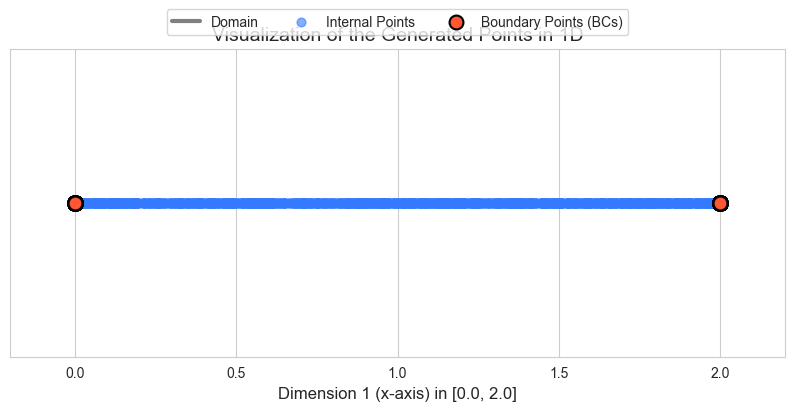

In [20]:
visualize_points_1d(x_int,x_bc, bounds_1d)

## Neural Network initialization

In [21]:
num_layers = 5
nodes_per_layer = 64
learning_rate = 0.001
epochs = 5000

model = network.DGMNet(nodes_per_layer, num_layers, 1).to(device)

trainer = DGMTrainer(
    model=model,
    pde_constants=PDE_CONSTANTS,
    learning_rate=learning_rate
)

## Training

In [22]:
trainer.train(
    epochs=epochs,
    interior_data=interior_data_1d,
    ic_data=ic_data_1d,
    bc_data=bc_data_1d,
    lambda_ic=50.0,
    lambda_bc=50.0
)

Starting training on mps. Interior: 1500, IC: 400, BC: 400 points.
Epoch 100/5000 | Total Loss: 1.2075 | L_pde: 0.0349 | L_ic: 0.0144 | L_bc: 0.0090
Epoch 200/5000 | Total Loss: 0.3308 | L_pde: 0.0103 | L_ic: 0.0042 | L_bc: 0.0022
Epoch 300/5000 | Total Loss: 0.4934 | L_pde: 0.0055 | L_ic: 0.0057 | L_bc: 0.0040
Epoch 400/5000 | Total Loss: 0.0336 | L_pde: 0.0031 | L_ic: 0.0005 | L_bc: 0.0001
Epoch 500/5000 | Total Loss: 0.0121 | L_pde: 0.0021 | L_ic: 0.0001 | L_bc: 0.0001
Epoch 600/5000 | Total Loss: 0.0060 | L_pde: 0.0014 | L_ic: 0.0001 | L_bc: 0.0000
Epoch 700/5000 | Total Loss: 0.0063 | L_pde: 0.0020 | L_ic: 0.0001 | L_bc: 0.0000
Epoch 800/5000 | Total Loss: 0.0028 | L_pde: 0.0010 | L_ic: 0.0000 | L_bc: 0.0000
Epoch 900/5000 | Total Loss: 0.0019 | L_pde: 0.0008 | L_ic: 0.0000 | L_bc: 0.0000
Epoch 1000/5000 | Total Loss: 0.0014 | L_pde: 0.0006 | L_ic: 0.0000 | L_bc: 0.0000
Epoch 1100/5000 | Total Loss: 0.0011 | L_pde: 0.0005 | L_ic: 0.0000 | L_bc: 0.0000
Epoch 1200/5000 | Total Loss:

## Visualization

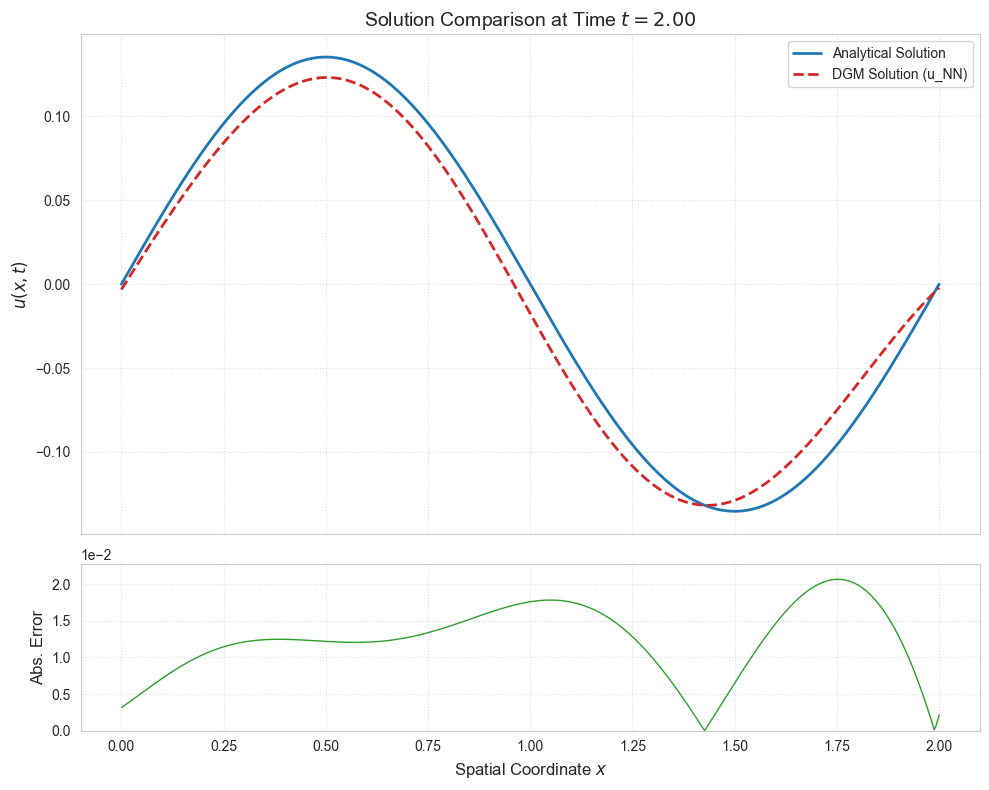

In [23]:
t_test_time = 2
visualize_solution(
    model=model,
    lx_1d=lx_1d,
    t_test=t_test_time,
    n_test_points=500
)

# Deep Galerkin Method in 2D

In [24]:
lx_2d = 2.0
ly_2d = 2.0
T_max = 2.0
bounds_2d = [[0.0, lx_2d],[0.0, ly_2d]]

# PDE Constants (for Heat Equation: u_t = alpha * u_xx + f)
ALPHA = 0.01
PDE_CONSTANTS = {'alpha': ALPHA}

# Data Sizes
N_INT = 2500
N_IC = 400
N_BC =400


## Data Preparation

In [25]:

# 1. Interior Data (t in [0, T_max], x in [0, lx_1d])
spatial_coords, t_int = generate_domain_points(N_INT, bounds_2d, T_max)
x_int = spatial_coords[:, 0:1]
y_int = spatial_coords[:, 1:2]
f_txy = source_term_fn_2D(t_int, x_int, y_int, ALPHA).to(device)
interior_data = (t_int, x_int, y_int,  f_txy)

# 2. Initial Condition Data (t = 0, x in [0, lx_1d])
spatial_coords_ic = generate_ic_points(N_IC, bounds_2d)
x_ic = spatial_coords_ic[:, 0:1]
y_ic = spatial_coords_ic[:, 1:2]
t_ic = torch.zeros_like(x_ic[:, 0:1]).to(device)
u_ic = initial_condition_fn_2D(x_ic,y_ic).to(device)
ic_data = (t_ic, x_ic, y_ic, u_ic)

# 3. Boundary Condition Data (t in [0, T_max], x = 0 or 1)
spatial_coords_bc = generate_boundary_points(N_BC, bounds_2d)
x_bc = spatial_coords_bc[:, 0:1]
y_bc = spatial_coords_bc[:, 1:2]
t_bc = torch.rand_like(x_bc[:, 0:1]) * T_max # Sample time for boundary points
u_bc = boundary_condition_fn_2D(t_bc, x_bc, y_bc).to(device)
bc_data = (t_bc, x_bc,y_bc, u_bc)

## Visualizing the sampled data

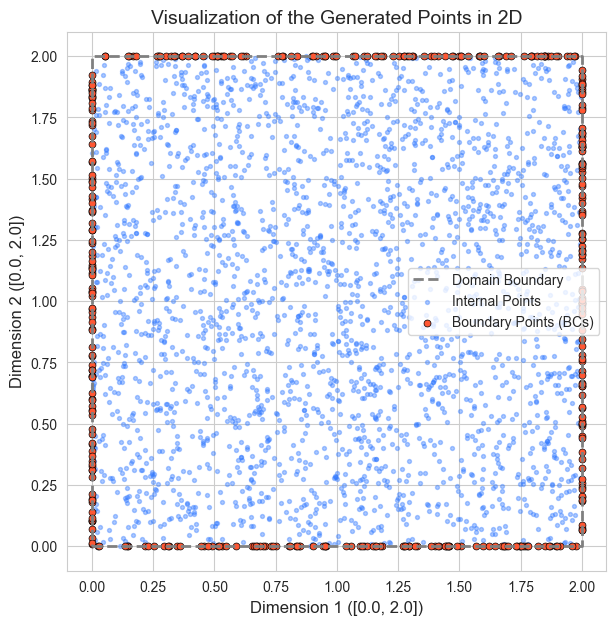

In [26]:
visualize_points_2d(spatial_coords, spatial_coords_bc, bounds_2d)

## Neural Network Initialization

In [27]:
num_layers = 6
nodes_per_layer = 64
learning_rate = 0.001
epochs = 6000

model = network.DGMNet(nodes_per_layer, num_layers, 2).to(device)

trainer = DGMTrainer_2D(
    model=model,
    pde_constants=PDE_CONSTANTS,
    learning_rate=learning_rate
)

## Training

In [28]:
trainer.train(
    epochs=epochs,
    interior_data=interior_data,
    ic_data=ic_data,
    bc_data=bc_data,
    lambda_ic=50.0,
    lambda_bc=50.0
)

Starting training on mps. Interior: 2500, IC: 400, BC: 400 points.
Epoch 100/6000 | Total Loss: 1.4817 | L_pde: 0.0231 | L_ic: 0.0192 | L_bc: 0.0100
Epoch 200/6000 | Total Loss: 0.4728 | L_pde: 0.0164 | L_ic: 0.0059 | L_bc: 0.0032
Epoch 300/6000 | Total Loss: 0.3353 | L_pde: 0.0135 | L_ic: 0.0041 | L_bc: 0.0023
Epoch 400/6000 | Total Loss: 0.4294 | L_pde: 0.0077 | L_ic: 0.0036 | L_bc: 0.0048
Epoch 500/6000 | Total Loss: 0.0402 | L_pde: 0.0043 | L_ic: 0.0004 | L_bc: 0.0003
Epoch 600/6000 | Total Loss: 0.0250 | L_pde: 0.0031 | L_ic: 0.0002 | L_bc: 0.0002
Epoch 700/6000 | Total Loss: 0.0169 | L_pde: 0.0024 | L_ic: 0.0001 | L_bc: 0.0002
Epoch 800/6000 | Total Loss: 0.0146 | L_pde: 0.0027 | L_ic: 0.0001 | L_bc: 0.0001
Epoch 900/6000 | Total Loss: 0.0103 | L_pde: 0.0019 | L_ic: 0.0001 | L_bc: 0.0001
Epoch 1000/6000 | Total Loss: 0.0082 | L_pde: 0.0015 | L_ic: 0.0000 | L_bc: 0.0001
Epoch 1100/6000 | Total Loss: 0.0067 | L_pde: 0.0013 | L_ic: 0.0000 | L_bc: 0.0001
Epoch 1200/6000 | Total Loss:

## Visualization

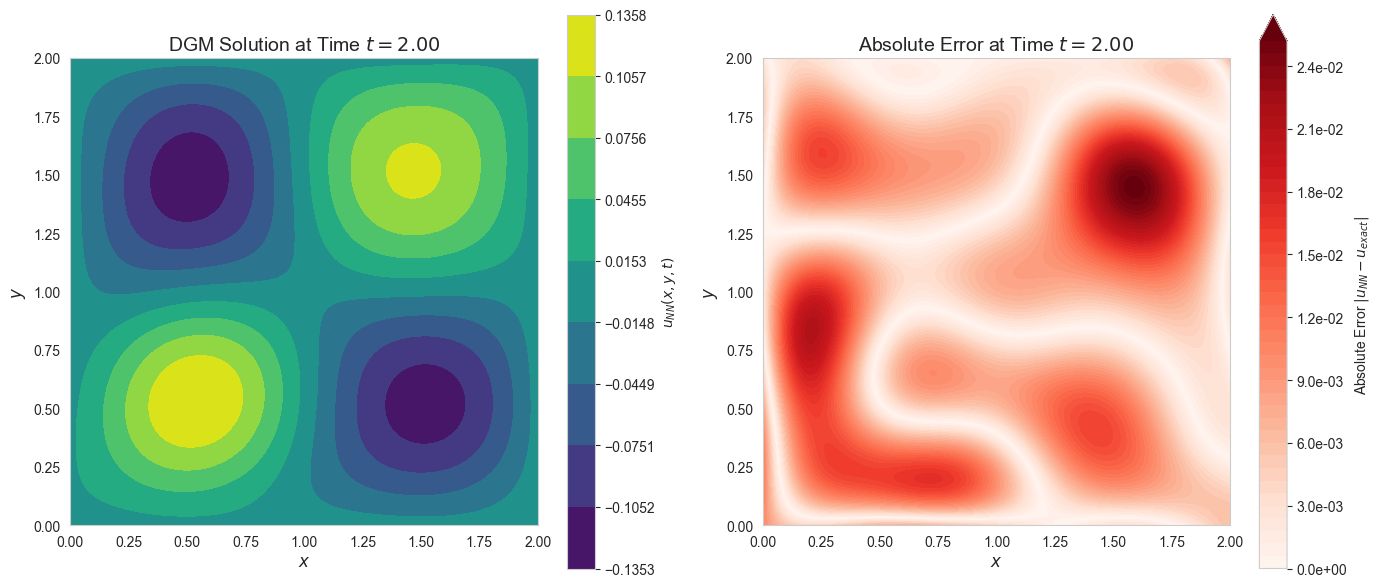

In [29]:
visualize_2d(
    model=model,
    bounds=bounds_2d,
    t_test=t_test_time,
    n_grid=500
)

ValueError: Invalid RGBA argument: 'viridis'

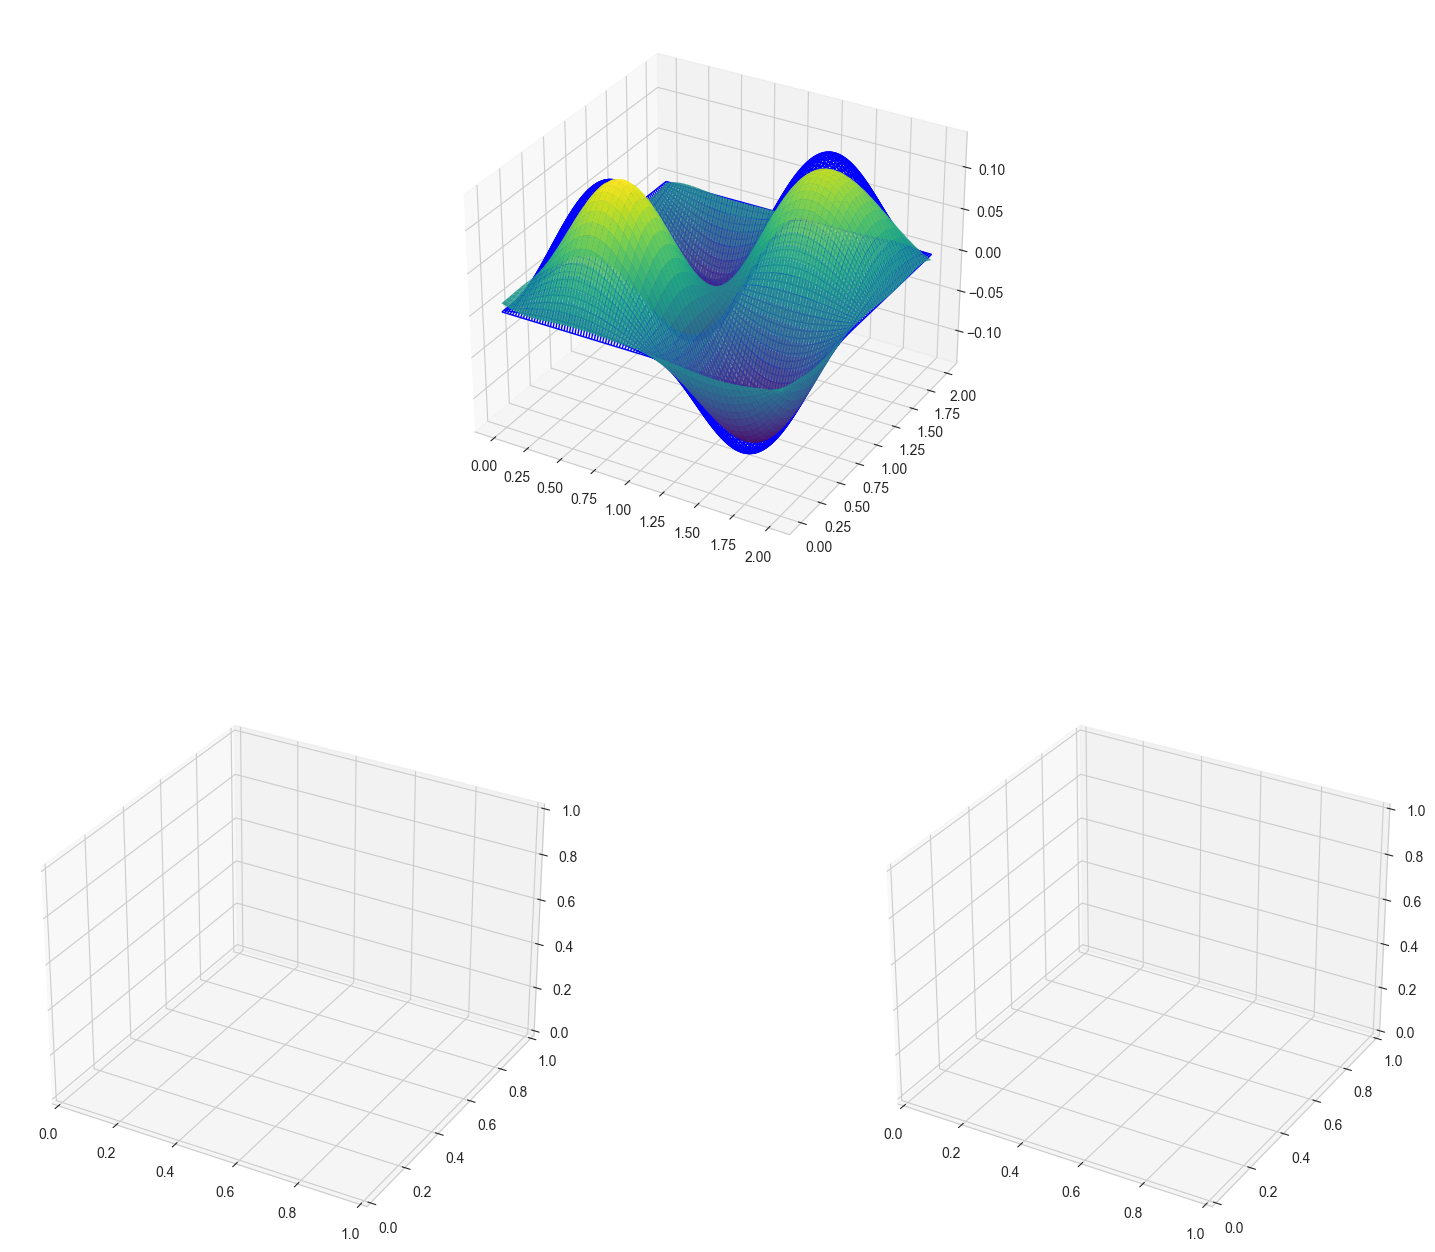

In [30]:
visualize_solution_2d(
    model=model,
    bounds=bounds_2d,
    t_test=t_test_time,
    n_grid=500
)